In [ ]:
!pip install pandasql

### Printed and handwritten text extraction from images using Tesseract and Google Cloud Vision API

Text extraction from image files is an useful technique for document digitalization. There are several well developed OCR engines for printed text extraction, such as Tesseract and EasyOCR [1]. However, for handwritten text extraction, it's more challenging because of large variations in handwritings from person to person. Tesseract and EasyOCR can't achieve satisfacting results unless the texts are hand printed. In this post, I will describe how to use Tesseract to extract printed texts, and use Google Cloud Vision API to extract handwritten texts.
<br>
<br>
The example text image file is from the IAM handwriting dataset [2]. 
<br>
<br>
The following major tools are used:<br>

**OpenCV**, For finding structures in the images to automatically break the images into printed segments and handwritten segments<br>
**Google Cloud Vision API**, For extract text from handwriting segment<br>
**Tesseract and Pytesseract**, For extract text from printed segment<br>


In [1]:
%reset -sf
from IPython.display import Image
from matplotlib import pyplot as plt
import pandas as pd, numpy as np
pd.options.display.float_format = '{:,.2f}'.format

from google.cloud import vision
import io

import warnings
warnings.simplefilter("ignore")

import os, cv2
os.chdir(r'C:\Users\rahul.rk\Desktop\eob_classification\JUNE\MS_FR\API\WordDetector-master\data\page')
         
fileList = [x for x in os.listdir() if 'png'  in x.lower()]
fileList[:5]

['1.png']

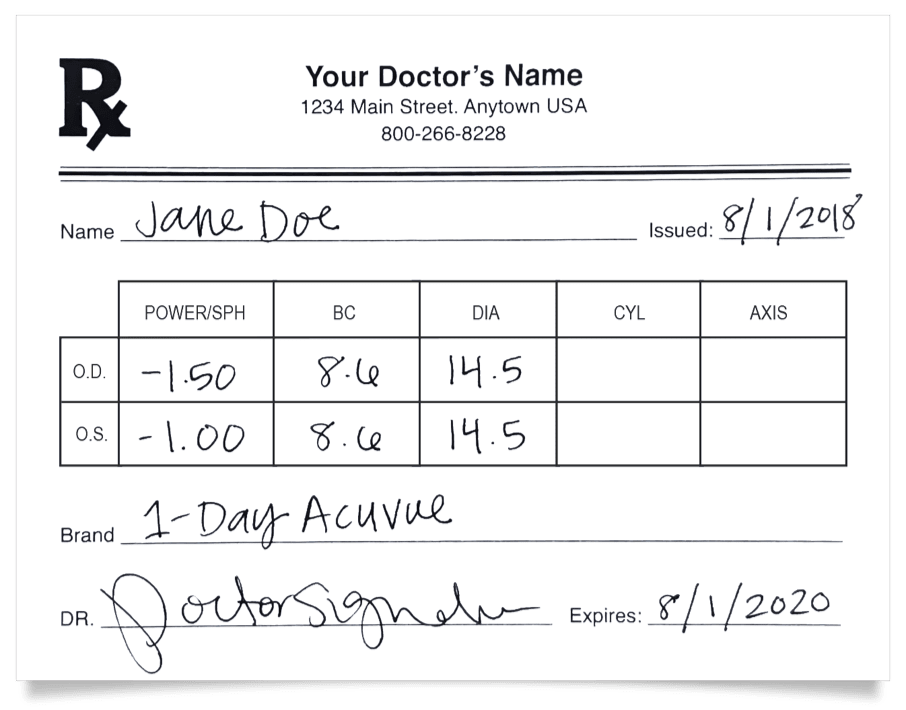

In [2]:
Image(filename = fileList[0], width = 300)

## Step 1. Page Segmentation

Use OpenCV to find lines between sections, and use the coordinates of the lines to break the image into segments.

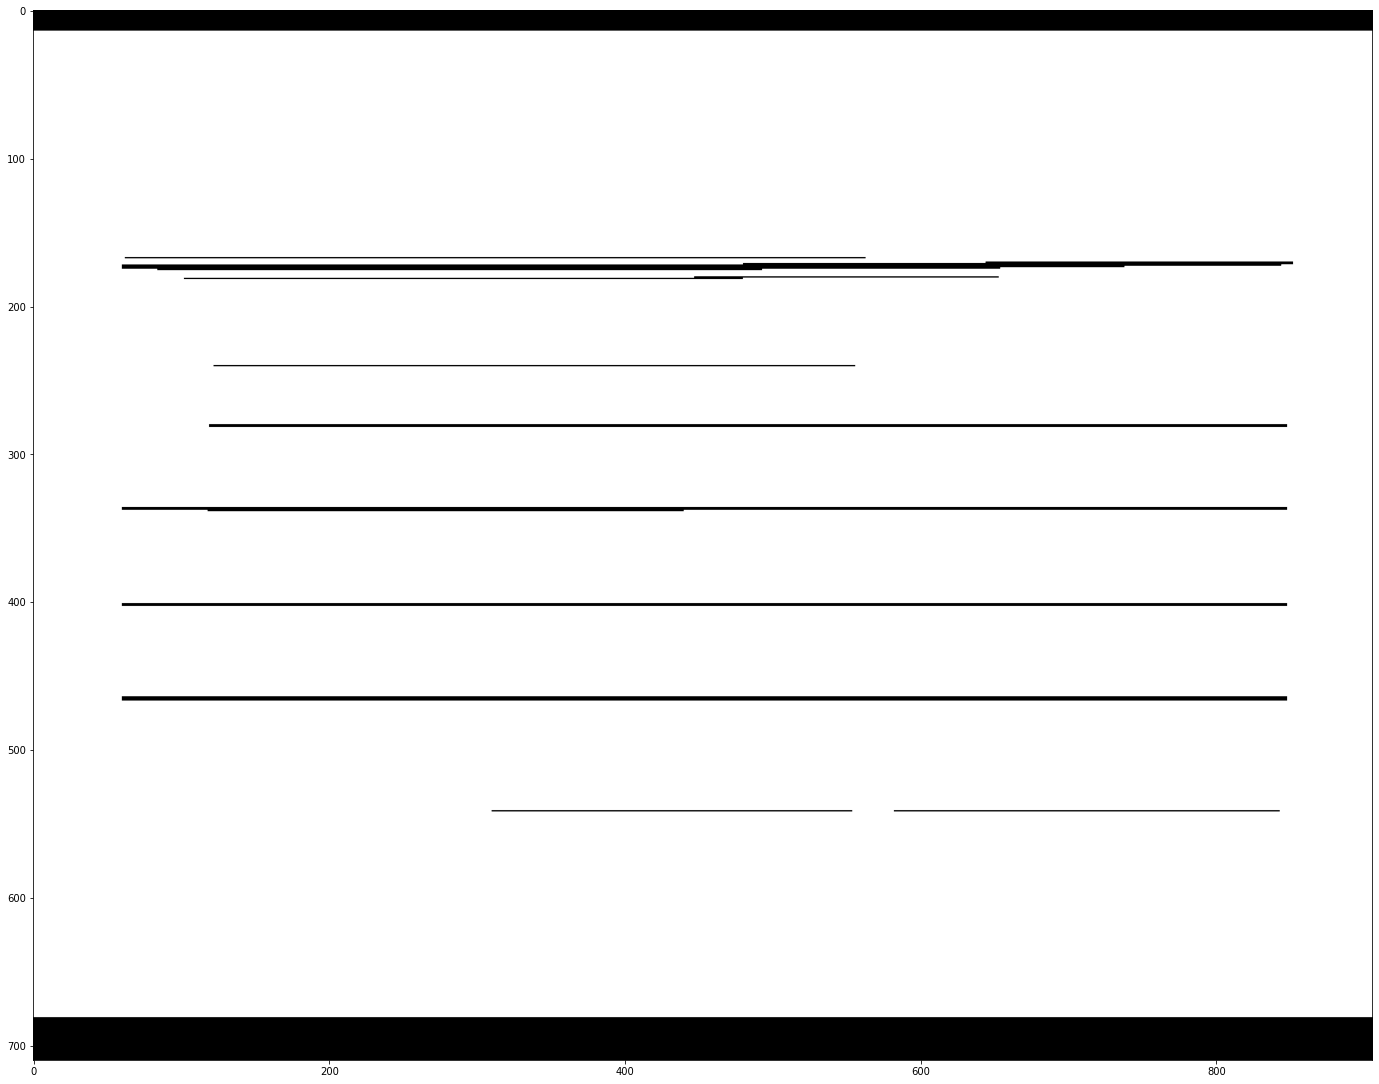

In [3]:
img = fileList[0]

def findHorizontalLines(img):
    img = cv2.imread(img) 
    
    #convert image to greyscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    return lineLocations

lineLocations = findHorizontalLines(img)
plt.figure(figsize=(24,24))
plt.imshow(lineLocations, cmap='Greys')

In [4]:
df_lineLocations = pd.DataFrame(lineLocations.sum(axis=1)).reset_index()
df_lineLocations.columns = ['rowLoc', 'LineLength']
df_lineLocations[df_lineLocations['LineLength'] > 0]

,rowLoc,LineLength
0,0,231030
1,1,231030
2,2,231030
3,3,231030
4,4,231030
...,...,...
705,705,231030
706,706,231030
707,707,231030
708,708,231030


In [5]:
df_lineLocations['line'] = 0
df_lineLocations['line'][df_lineLocations['LineLength'] > 100] = 1

df_lineLocations['cumSum'] = df_lineLocations['line'].cumsum()

In [6]:
df_lineLocations.head()

,rowLoc,LineLength,line,cumSum
0,0,231030,1,1
1,1,231030,1,2
2,2,231030,1,3
3,3,231030,1,4
4,4,231030,1,5


In [7]:
import pandasql as ps

query = '''
select row_number() over (order by cumSum) as SegmentOrder
, min(rowLoc) as SegmentStart
, max(rowLoc) - min(rowLoc) as Height
from df_lineLocations
where line = 0
--and CumSum !=0
group by cumSum
'''

df_SegmentLocations  = ps.sqldf(query, locals())
df_SegmentLocations

,SegmentOrder,SegmentStart,Height
0,1,14,152
1,2,168,1
2,3,176,3
3,4,182,57
4,5,241,38
5,6,282,53
6,7,339,61
7,8,403,60
8,9,467,73
9,10,542,138


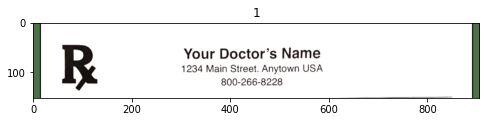

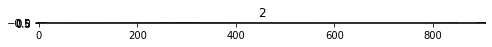

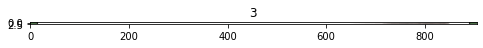

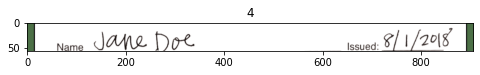

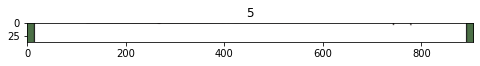

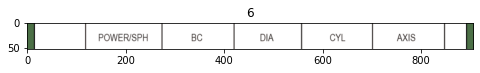

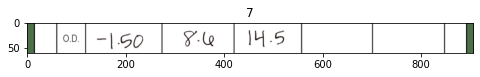

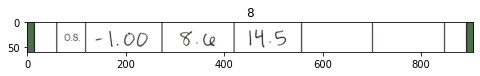

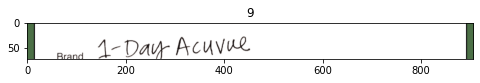

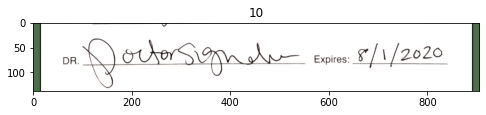

In [8]:
def pageSegmentation1(img, w, df_SegmentLocations):
    img = cv2.imread(img) 
    im2 = img.copy()
    segments = []

    for i in range(len(df_SegmentLocations)):
        y = df_SegmentLocations['SegmentStart'][i]
        h = df_SegmentLocations['Height'][i]

        cropped = im2[y:y + h, 0:w] 
        segments.append(cropped)
        plt.figure(figsize=(8,8))
        plt.imshow(cropped)
        plt.title(str(i+1))        

    return segments

img = fileList[0]
w = lineLocations.shape[1]
segments = pageSegmentation1(img, w, df_SegmentLocations)

# Step 2. Extract Printed Text

In [9]:
# Extract text from image with two columns of contents
import re
import cv2
import pytesseract
from pytesseract import Output

# tell pytesseract where the engine is installed
pytesseract.pytesseract.tesseract_cmd = 'C:/Users/rahul.rk/AppData/Local/Programs/Tesseract-OCR/tesseract.exe'


def extractTextFromImg(segment):
    text = pytesseract.image_to_string(segment, lang='eng')         
    text = text.encode("gbk", 'ignore').decode("gbk", "ignore")
        
    return text

In [16]:
segment = [segments[0],segments[3],segments[5],segments[6],segments[7],segments[8],segments[9]]

for seg in segment:
    segment = seg
    text = extractTextFromImg(segment)
    print(text)

Your Doctor’s Name
1234 Main Street. Anytown USA
800-266-8228

| Name JAMZ Dor Issued: $/ 1/208 i

 

POWER/SPH |

BC

 

0.D.

 

-|50 | -@ | 14-5 |

 

Os.

 

-\.00 | 8.@ | 14.5 |

a A-Dayy ACUVur

 

| ah) USI gh Expires: v1 [2020

